In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /Users/max/.keras/datasets/iris_training.csv


In [3]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [4]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [5]:
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [6]:
train_dataset = train_dataset.map(pack_features_vector)

In [7]:
features, labels = next(iter(train_dataset))

In [8]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)), 
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

predictions = model(features)

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
    y_ = model(x, training=training)

    return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)\

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Epoch 000: Loss: 1.890, Accuracy: 16.667%
Epoch 050: Loss: 0.459, Accuracy: 85.000%
Epoch 100: Loss: 0.304, Accuracy: 96.667%


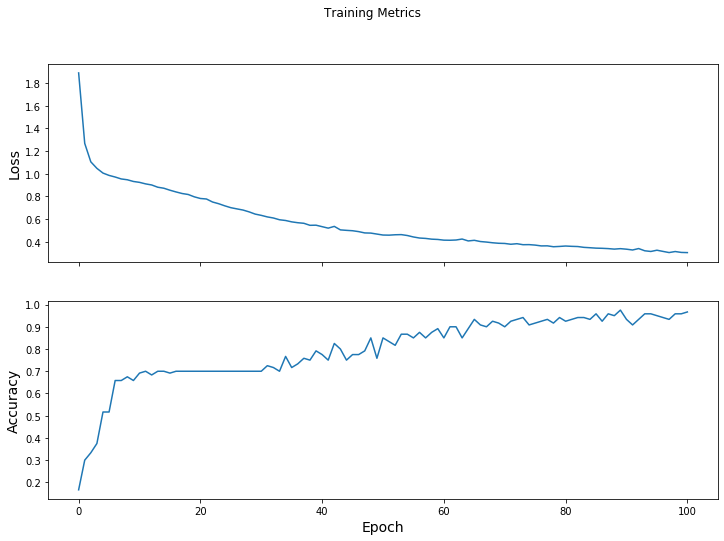

In [10]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 101

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        epoch_accuracy.update_state(y, model(x, training=True))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [11]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (94.0%)
Example 1 prediction: Iris versicolor (62.2%)
Example 2 prediction: Iris virginica (70.5%)
